# Connect 4; InferProvenance

This workbook contains a worked example of inferring provenance in abstract systems through the use of Answer Set Programming and Graph Analysis.

For this example, we use the popular boardgame [Connect Four](https://en.wikipedia.org/wiki/Connect_Four), in which players take turns placing coloured disks into a grid.

In [1]:
#Define the constants of the game
NUM_ROWS = 3
NUM_COLS = 3

COLOURS = ['red', 'yellow']

## Ground Truth

First, we generate a set of "known provenance" to be used; here we are randomly creating one game of Connect-4. It won't be optimal play, but that's okay; the important thing is we have a known chain of provenance for each move.

In a "real" example of course, there would not be a known chain - hence the inference! - but this allows us to compare the different inferred paths with the true provenance, to determine how close each is, and how we should (or could) select the "best" answer.

In theory, being able to generate a large volume of different examples, may also allow us to use Machine Learning techniques to teach the system how best to decide on the final provenance.

In [2]:
import random

In [3]:
#Randomly choose a free column
def choose_move(board):
    columns = list(range(NUM_COLS))
    random.shuffle(columns)
    while columns:
        x = columns.pop()
        if board[NUM_ROWS-1][x] == "empty":
            for y in range(NUM_ROWS-1, 0-1, -1):
                if board[y][x] != "empty":
                    return x, y+1
                elif y == 0:
                    return x, y

    raise Exception("No possible moves!")

In [4]:
#Check whether a board has been "won"
def has_won(board):
    # Check horizontals
    for j in range(NUM_ROWS-3):
        for i in range(NUM_COLS):
            if board[j][i] != "empty" and board[j][i] == board[j+1][i] == board[j+2][i] == board[j+3][i]:
                return True


    # Check verticals
    for i in range(NUM_COLS-3):
        for j in range(NUM_ROWS):
            if board[j][i] != "empty" and board[j][i] == board[j][i+1] == board[j][i+2] == board[j][i+3]:
                return True
            

    # Check "ascending" diagonals
    for i in range(3, NUM_COLS):
        for j in range(NUM_ROWS-3):
            if board[j][i] != "empty" and board[j][i] == board[j+1][i-1] == board[j+2][i-2] == board[j+3][i-3]:
                return True

    
    # Check "descending" diagonals
    for i in range(3, NUM_COLS):
        for j in range(3, NUM_ROWS):
            if board[j][i] != "empty" and board[j][i] == board[j-1][i-1] == board[j-2][i-2] == board[j-3][i-3]:
                return True


    return False

In [5]:
known_provenance = []

board = [["empty" for x in range(NUM_COLS)] for y in range(NUM_ROWS)]


current_player = 0
known_provenance.append('-'.join([ cell for row in board for cell in row ]))

while not has_won(board):    
    try:
        x, y = choose_move(board)
    except:
        break # No possible moves
        
    board[y][x] = COLOURS[current_player]
    known_provenance.append('-'.join([ cell for row in board for cell in row ]))
    
    current_player = (current_player + 1) % 2


In [6]:
known_start = known_provenance[0]
known_end = known_provenance[len(known_provenance)-1]
known_provenance

['empty-empty-empty-empty-empty-empty-empty-empty-empty',
 'red-empty-empty-empty-empty-empty-empty-empty-empty',
 'red-yellow-empty-empty-empty-empty-empty-empty-empty',
 'red-yellow-empty-red-empty-empty-empty-empty-empty',
 'red-yellow-empty-red-empty-empty-yellow-empty-empty',
 'red-yellow-red-red-empty-empty-yellow-empty-empty',
 'red-yellow-red-red-empty-yellow-yellow-empty-empty',
 'red-yellow-red-red-red-yellow-yellow-empty-empty',
 'red-yellow-red-red-red-yellow-yellow-yellow-empty',
 'red-yellow-red-red-red-yellow-yellow-yellow-red']

In [7]:
import os
from cairosvg import svg2png
import networkx as nx
import matplotlib.pyplot as plt
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

In [8]:
def create_node_image(node, filename=None):
    
    SVG_MAX_SIZE = 50
    
    BOARD_COLOUR = "#0058db"
    EMPTY_COLOUR = "#003a91"
    P1_COLOUR = "#e30000"
    P2_COLOUR = "#f5f50a"
    

    if not filename:
        filename = "{}x{}/{}.png".format(
            NUM_COLS,
            NUM_ROWS,
            node
        )
        
    
    if NUM_COLS == NUM_ROWS:
        svg_height = SVG_MAX_SIZE
        svg_width = SVG_MAX_SIZE
    elif NUM_COLS > NUM_ROWS:
        svg_width = SVG_MAX_SIZE
        svg_height = SVG_MAX_SIZE * (float(NUM_ROWS)/NUM_COLS)
    else:
        svg_height = SVG_MAX_SIZE
        svg_width = SVG_MAX_SIZE * (float(NUM_COLS)/NUM_ROWS)
    
    
    cell_size = float(svg_width)/NUM_COLS
    
    
    rows_str = ""
    
    #Split cells into rows
    cells = node.split("-")
    row_number = NUM_ROWS
    for i in range(0, len(cells), NUM_COLS):
        row = cells[i:i + NUM_COLS]
        
        row_str = ""
        row_y = (row_number * cell_size) - (float(cell_size)/2)
        
        for x, cell in enumerate(row):
            
            
            
            if cell == COLOURS[0]:
                colour = P1_COLOUR
            elif cell == COLOURS[1]:
                colour = P2_COLOUR
            else:
                colour = EMPTY_COLOUR
            
            row_str += '<circle cx="{}" cy="{}" r="{}" fill="{}"/>'.format(
                ((x+1) * cell_size) - (float(cell_size)/2),
                row_y,
                (cell_size * 0.85)/2,
                colour
            )
            
            
        rows_str = row_str + rows_str    
        row_number -= 1
            
            
            
    svg_str = '<?xml version="1.0" encoding="UTF-8"?><svg version="1.1" xmlns="http://www.w3.org/2000/svg" width="{0}" height="{1}"><rect width="{0}" height="{1}" fill="{2}" />{3}</svg>'.format(
        svg_width,
        svg_height,
        BOARD_COLOUR,
        rows_str,
    )
    
    #For some reason graphviz won't load svgs. So we convert it to png
    svg2png(bytestring=svg_str,write_to=filename)

    

In [9]:
def get_node_image(node):

    filename = "imgs/{}x{}/{}.png".format(
        NUM_COLS,
        NUM_ROWS,
        node
    )
    
    dirname = os.path.abspath('')
    filename = os.path.join(dirname, filename)
    
    if not os.path.isfile(filename):
        if not os.path.isdir(os.path.join(dirname, 'imgs/{}x{}').format(NUM_COLS, NUM_ROWS)):
            os.mkdir(os.path.join(dirname, 'imgs/{}x{}').format(NUM_COLS, NUM_ROWS))
        create_node_image(node, filename)
        
    return filename

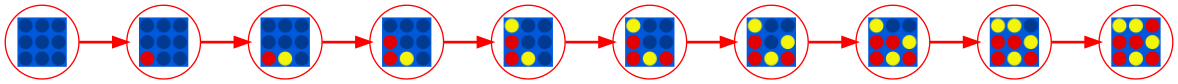

In [10]:
# Draw a graph of the known prov
G = nx.DiGraph()
for start_node, end_node in zip(known_provenance, known_provenance[1:]):    
    G.add_node(start_node, label=" ", image=get_node_image(start_node), color='red')
    G.add_node(end_node, label=" ", image=get_node_image(end_node), color='red')
    
    G.add_edge(start_node, end_node, penwidth=2, color='red')
G.graph['layout'] = 'dot'
G.graph['rankdir'] = 'LR'
draw(G, format='png',filename='output/{}x{}/known.png'.format(NUM_COLS, NUM_ROWS))

## Rule Expansion
In this next section, we build up the rules for the clingo reasoner, that allow us to expand to the set of all possible moves.

Because we have a `know_start` and `known_end` state, we can ensure that the we discard all states that are inconsistent with either. This *massively* reduces the state-space for the solver, allowing us to apply this to more complex grids, and preventing the solver running infitely.

In [11]:
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_nb_helper import ASPRules

In [12]:
%load_ext PWE_NB_Extension

In [13]:
c4_rules = []

c4_rules.append('% schema contents(COLOUR)')
c4_rules.append('contents(empty;{}).'.format(';'.join(COLOURS)))


c4_rules.append('% schema equal_or_empty(CELL1, CELL2)')
c4_rules.append('equal_or_empty(Cell1, Cell2) :- Cell1 = empty, contents(Cell2).')
c4_rules.append('equal_or_empty(Cell1, Cell2) :- Cell1 = Cell2, contents(Cell1), contents(Cell2).')


#Create rules for moving from one board state to the next
start_cells = ["CELL_{}_{}_START".format(x, y) for y in range(NUM_ROWS) for x in range(NUM_COLS)]
end_cells = ["CELL_{}_{}_END".format(x, y) for y in range(NUM_ROWS) for x in range(NUM_COLS)]
c4_rules.append('% schema e(TIME, {}, {})'.format(
    ", ".join(start_cells),
    ", ".join(end_cells),
))


cells = ['Cell_{}_{}'.format(x, y) for y in range(NUM_ROWS) for x in range(NUM_COLS)]


#Each cell requires a set of rules to define a valid move
for j in range(NUM_ROWS):
    for i in range(NUM_COLS):
            
        # Create cells for the start and end states
        end_board = []
        start_valid = []
        end_valid = []
        
        for y in range(NUM_ROWS):
            for x in range(NUM_COLS):

                if x == i and y == j:
                    end_board.append('Cell_{}_{}_'.format(x, y))
                    start_valid.append('Cell_{}_{} = empty'.format(x, y))
                    end_valid.append('Cell_{}_{}_ = Piece'.format(x, y))
                    end_valid.append('contents(Cell_{}_{}_)'.format(x, y))
                
                    #Any added piece must not have an empty cell below it
                    if j != 0:
                        end_valid.append('Cell_{}_{} != empty'.format(x, y-1))
                    
                else:
                    end_board.append('Cell_{}_{}'.format(x, y))
                    start_valid.append('contents(Cell_{}_{})'.format(x, y))

        
        
        
        
        #We must constrain the output to something consistent with the known endstate
        #Otherwise the possible states will balloon (potentially) infinitely
        consistent_with_known = ["equal_or_empty({}, {})".format(end_cell, known_cell) for end_cell, known_cell in zip(end_board, known_end.split("-"))]
        
        #There must be an existing edge, with an endstate that matches the startstate of THIS edge
        existing_edge = "e(T-1, {0},{1})".format(
                ",".join(["_" for cell in range(len(cells))]),
                ",".join(cells),
        )

        c4_rules.append('e(T, {0}, {1}) :- {2},{3},{4},{5},{6}.'.format(
            ",".join(cells),
            ",".join(end_board),
            ",".join(start_valid),
            ",".join(end_valid),
            ",".join(consistent_with_known),
            existing_edge,
            "T\\2=1, Piece={}".format(COLOURS[0]),
            
        ))

        c4_rules.append('e(T, {0}, {1}) :- {2},{3},{4},{5},{6}.'.format(
            ",".join(cells),
            ",".join(end_board),
            ",".join(start_valid),
            ",".join(end_valid),
            ",".join(consistent_with_known),
            existing_edge,
            "T\\2=0, Piece={}".format(COLOURS[1]),
            
        ))
        
        # OR
        
        # If there is no existing edge, tt must be the first move; therefore the start state must be all empty
        c4_rules.append('e(T, {0}, {1}) :- {2},{3},{4},{5},{6}.'.format(
            ",".join(cells),
            ",".join(end_board),
            ",".join(start_valid),
            ",".join(end_valid),
            ",".join(consistent_with_known),
            ",".join(["{}={},T=1".format(cell, value) for cell, value in zip(cells, known_start.split("-"))]), #Note the use of known_start here
            "Piece={}".format(COLOURS[0]),
            
        ))


#TODO: Winning state checks


Alternatively, we can use the below code to demonstrate a "poorly defined" language (which in this case is lacking the constraint that players must take turns) to observe the effects this has on the generated map of provenances.

In [14]:
# c4_rules = []

# c4_rules.append('% schema contents(COLOUR)')
# c4_rules.append('contents(empty;{}).'.format(';'.join(COLOURS)))


# c4_rules.append('% schema equal_or_empty(CELL1, CELL2)')
# c4_rules.append('equal_or_empty(Cell1, Cell2) :- Cell1 = empty, contents(Cell2).')
# c4_rules.append('equal_or_empty(Cell1, Cell2) :- Cell1 = Cell2, contents(Cell1), contents(Cell2).')


# #Create rules for moving from one board state to the next
# start_cells = ["CELL_{}_{}_START".format(x, y) for y in range(NUM_ROWS) for x in range(NUM_COLS)]
# end_cells = ["CELL_{}_{}_END".format(x, y) for y in range(NUM_ROWS) for x in range(NUM_COLS)]
# c4_rules.append('% schema e(TIME, {}, {})'.format(
#     ", ".join(start_cells),
#     ", ".join(end_cells),
# ))


# cells = ['Cell_{}_{}'.format(x, y) for y in range(NUM_ROWS) for x in range(NUM_COLS)]


# #Each cell requires a set of rules to define a valid move
# for j in range(NUM_ROWS):
#     for i in range(NUM_COLS):
            
#         # Create cells for the start and end states
#         end_board = []
#         start_valid = []
#         end_valid = []
        
#         for y in range(NUM_ROWS):
#             for x in range(NUM_COLS):

#                 if x == i and y == j:
#                     end_board.append('Cell_{}_{}_'.format(x, y))
#                     start_valid.append('Cell_{}_{} = empty'.format(x, y))
#                     end_valid.append('Cell_{}_{}_ != empty'.format(x, y))
#                     end_valid.append('contents(Cell_{}_{}_)'.format(x, y))
                
#                     #Any added piece must not have an empty cell below it
#                     if j != 0:
#                         end_valid.append('Cell_{}_{} != empty'.format(x, y-1))
                    
#                 else:
#                     end_board.append('Cell_{}_{}'.format(x, y))
#                     start_valid.append('contents(Cell_{}_{})'.format(x, y))

        
        
        
        
#         #We must constrain the output to something consistent with the known endstate
#         #Otherwise the possible states will balloon (potentially) infinitely
#         consistent_with_known = ["equal_or_empty({}, {})".format(end_cell, known_cell) for end_cell, known_cell in zip(end_board, known_end.split("-"))]
        
#         #There must be an existing edge, with an endstate that matches the startstate of THIS edge
#         existing_edge = "e(T-1, {0},{1})".format(
#                 ",".join(["_" for cell in range(len(cells))]),
#                 ",".join(cells),
#         )

#         c4_rules.append('e(T, {0}, {1}) :- {2},{3},{4},{5}.'.format(
#             ",".join(cells),
#             ",".join(end_board),
#             ",".join(start_valid),
#             ",".join(end_valid),
#             ",".join(consistent_with_known),
#             existing_edge, 
#         ))
        
#         # OR
        
#         # If there is no existing edge, tt must be the first move; therefore the start state must be all empty
#         c4_rules.append('e(T, {0}, {1}) :- {2},{3},{4},{5}.'.format(
#             ",".join(cells),
#             ",".join(end_board),
#             ",".join(start_valid),
#             ",".join(end_valid),
#             ",".join(consistent_with_known),
#             ",".join(["{}={},T=1".format(cell, value) for cell, value in zip(cells, known_start.split("-"))]), #Note the use of known_start here   
#         ))


In [15]:
#Print out the full ruleset
ASPRules('\n'.join(c4_rules))

'% schema contents(COLOUR)\ncontents(empty;red;yellow).\n% schema equal_or_empty(CELL1, CELL2)\nequal_or_empty(Cell1, Cell2) :- Cell1 = empty, contents(Cell2).\nequal_or_empty(Cell1, Cell2) :- Cell1 = Cell2, contents(Cell1), contents(Cell2).\n% schema e(TIME, CELL_0_0_START, CELL_1_0_START, CELL_2_0_START, CELL_0_1_START, CELL_1_1_START, CELL_2_1_START, CELL_0_2_START, CELL_1_2_START, CELL_2_2_START, CELL_0_0_END, CELL_1_0_END, CELL_2_0_END, CELL_0_1_END, CELL_1_1_END, CELL_2_1_END, CELL_0_2_END, CELL_1_2_END, CELL_2_2_END)\ne(T, Cell_0_0,Cell_1_0,Cell_2_0,Cell_0_1,Cell_1_1,Cell_2_1,Cell_0_2,Cell_1_2,Cell_2_2, Cell_0_0_,Cell_1_0,Cell_2_0,Cell_0_1,Cell_1_1,Cell_2_1,Cell_0_2,Cell_1_2,Cell_2_2) :- Cell_0_0 = empty,contents(Cell_1_0),contents(Cell_2_0),contents(Cell_0_1),contents(Cell_1_1),contents(Cell_2_1),contents(Cell_0_2),contents(Cell_1_2),contents(Cell_2_2),Cell_0_0_ = Piece,contents(Cell_0_0_),equal_or_empty(Cell_0_0_, red),equal_or_empty(Cell_1_0, yellow),equal_or_empty(Cell_2_0, red),equal_or_empty(Cell_0_1, red),equal_or_empty(Cell_1_1, red),equal_or_empty(Cell_2_1, yellow),equal_or_empty(Cell_0_2, yellow),equal_or_empty(Cell_1_2, yellow),equal_or_empty(Cell_2_2, red),e(T-1, _,_,_,_,_,_,_,_,_,Cell_0_0,Cell_1_0,Cell_2_0,Cell_0_1,Cell_1_1,Cell_2_1,Cell_0_2,Cell_1_2,Cell_2_2),T\\2=1, Piece=red.\ne(T, Cell_0_0,Cell_1_0,Cell_2_0,Cell_0_1,Cell_1_1,Cell_2_1,Cell_0_2,Cell_1_2,Cell_2_2, Cell_0_0_,Cell_1_0,Cell_2_0,Cell_0_1,Cell_1_1,Cell_2_1,Cell_0_2,Cell_1_2,Cell_2_2) :- Cell_0_0 = empty,contents(Cell_1_0),contents(Cell_2_0),contents(Cell_0_1),contents(Cell_1_1),contents(Cell_2_1),contents(Cell_0_2),contents(Cell_1_2),contents(Cell_2_2),Cell_0_0_ = Piece,contents(Cell_0_0_),equal_or_empty(Cell_0_0_, red),equal_or_empty(Cell_1_0, yellow),equal_or_empty(Cell_2_0, red),equal_or_empty(Cell_0_1, red),equal_or_empty(Cell_1_1, red),equal_or_empty(Cell_2_1, yellow),equal_or_empty(Cell_0_2, yellow),equal_or_empty(Cell_1_2, yellow),equal_or_empty(Cell_2_2, red),e(T-1, _,_,_,_,_,_,_,_,_,Cell_0_0,Cell_1_0,Cell_2_0,Cell_0_1,Cell_1_1,Cell_2_1,Cell_0_2,Cell_1_2,Cell_2_2),T\\2=0, Piece=yellow.\ne(T, Cell_0_0,Cell_1_0,Cell_2_0,Cell_0_1,Cell_1_1,Cell_2_1,Cell_0_2,Cell_1_2,Cell_2_2, Cell_0_0_,Cell_1_0,Cell_2_0,Cell_0_1,Cell_1_1,Cell_2_1,Cell_0_2,Cell_1_2,Cell_2_2) :- Cell_0_0 = empty,contents(Cell_1_0),contents(Cell_2_0),contents(Cell_0_1),contents(Cell_1_1),contents(Cell_2_1),contents(Cell_0_2),contents(Cell_1_2),contents(Cell_2_2),Cell_0_0_ = Piece,contents(Cell_0_0_),equal_or_empty(Cell_0_0_, red),equal_or_empty(Cell_1_0, yellow),equal_or_empty(Cell_2_0, red),equal_or_empty(Cell_0_1, red),equal_or_empty(Cell_1_1, red),equal_or_empty(Cell_2_1, yellow),equal_or_empty(Cell_0_2, yellow),equal_or_empty(Cell_1_2, yellow),equal_or_empty(Cell_2_2, red),Cell_0_0=empty,T=1,Cell_1_0=empty,T=1,Cell_2_0=empty,T=1,Cell_0_1=empty,T=1,Cell_1_1=empty,T=1,Cell_2_1=empty,T=1,Cell_0_2=empty,T=1,Cell_1_2=empty,T=1,Cell_2_2=empty,T=1,Piece=red.\ne(T, Cell_0_0,Cell_1_0,Cell_2_0,Cell_0_1,Cell_1_1,Cell_2_1,Cell_0_2,Cell_1_2,Cell_2_2, Cell_0_0,Cell_1_0_,Cell_2_0,Cell_0_1,Cell_1_1,Cell_2_1,Cell_0_2,Cell_1_2,Cell_2_2) :- contents(Cell_0_0),Cell_1_0 = empty,contents(Cell_2_0),contents(Cell_0_1),contents(Cell_1_1),contents(Cell_2_1),contents(Cell_0_2),contents(Cell_1_2),contents(Cell_2_2),Cell_1_0_ = Piece,contents(Cell_1_0_),equal_or_empty(Cell_0_0, red),equal_or_empty(Cell_1_0_, yellow),equal_or_empty(Cell_2_0, red),equal_or_empty(Cell_0_1, red),equal_or_empty(Cell_1_1, red),equal_or_empty(Cell_2_1, yellow),equal_or_empty(Cell_0_2, yellow),equal_or_empty(Cell_1_2, yellow),equal_or_empty(Cell_2_2, red),e(T-1, _,_,_,_,_,_,_,_,_,Cell_0_0,Cell_1_0,Cell_2_0,Cell_0_1,Cell_1_1,Cell_2_1,Cell_0_2,Cell_1_2,Cell_2_2),T\\2=1, Piece=red.\ne(T, Cell_0_0,Cell_1_0,Cell_2_0,Cell_0_1,Cell_1_1,Cell_2_1,Cell_0_2,Cell_1_2,Cell_2_2, Cell_0_0,Cell_1_0_,Cell_2_0,Cell_0_1,Cell_1_1,Cell_2_1,Cell_0_2,Cell_1_2,Cell_2_2) :- contents(Cell_0_0),Cell_1_0 = empty,contents(Cell_2_0),contents(Cell_0_1),con

In [16]:
#Run this code using clingo
%clingo -l c4_rules --saveto clingo_soln --save_meta_data_to meta_data --donot-display_input

ANTLR runtime and generated code versions disagree: 4.8!=4.7.1
ANTLR runtime and generated code versions disagree: 4.8!=4.7.1
Output:


'Answer: 1\ncontents(empty) contents(red) contents(yellow) equal_or_empty(empty,empty) equal_or_empty(empty,red) equal_or_empty(empty,yellow) equal_or_empty(red,red) equal_or_empty(yellow,yellow) e(1,empty,empty,empty,empty,empty,empty,empty,empty,empty,red,empty,empty,empty,empty,empty,empty,empty,empty) e(1,empty,empty,empty,empty,empty,empty,empty,empty,empty,empty,empty,red,empty,empty,empty,empty,empty,empty) e(2,empty,empty,red,empty,empty,empty,empty,empty,empty,empty,empty,red,empty,empty,yellow,empty,empty,empty) e(2,empty,empty,red,empty,empty,empty,empty,empty,empty,empty,yellow,red,empty,empty,empty,empty,empty,empty) e(2,red,empty,empty,empty,empty,empty,empty,empty,empty,red,yellow,empty,empty,empty,empty,empty,empty,empty) e(3,empty,empty,red,empty,empty,yellow,empty,empty,empty,empty,empty,red,empty,empty,yellow,empty,empty,red) e(3,red,yellow,empty,empty,empty,empty,empty,empty,empty,red,yellow,empty,empty,red,empty,empty,empty,empty) e(3,empty,yellow,red,empty,empty,empty,empty,empty,empty,empty,yellow,red,empty,red,empty,empty,empty,empty) e(3,red,yellow,empty,empty,empty,empty,empty,empty,empty,red,yellow,empty,red,empty,empty,empty,empty,empty) e(3,red,yellow,empty,empty,empty,empty,empty,empty,empty,red,yellow,red,empty,empty,empty,empty,empty,empty) e(3,empty,yellow,red,empty,empty,empty,empty,empty,empty,red,yellow,red,empty,empty,empty,empty,empty,empty) e(3,empty,empty,red,empty,empty,yellow,empty,empty,empty,red,empty,red,empty,empty,yellow,empty,empty,empty) e(4,empty,yellow,red,empty,red,empty,empty,empty,empty,empty,yellow,red,empty,red,empty,empty,yellow,empty) e(4,red,yellow,empty,empty,red,empty,empty,empty,empty,red,yellow,empty,empty,red,empty,empty,yellow,empty) e(4,red,yellow,empty,red,empty,empty,empty,empty,empty,red,yellow,empty,red,empty,empty,yellow,empty,empty) e(4,red,yellow,red,empty,empty,empty,empty,empty,empty,red,yellow,red,empty,empty,yellow,empty,empty,empty) e(4,empty,yellow,red,empty,red,empty,empty,empty,empty,empty,yellow,red,empty,red,yellow,empty,empty,empty) e(4,red,empty,red,empty,empty,yellow,empty,empty,empty,red,yellow,red,empty,empty,yellow,empty,empty,empty) e(4,empty,empty,red,empty,empty,yellow,empty,empty,red,empty,yellow,red,empty,empty,yellow,empty,empty,red) e(5,red,yellow,red,empty,empty,yellow,empty,empty,empty,red,yellow,red,empty,empty,yellow,empty,empty,red) e(5,empty,yellow,red,empty,red,yellow,empty,empty,empty,empty,yellow,red,empty,red,yellow,empty,empty,red) e(5,empty,yellow,red,empty,empty,yellow,empty,empty,red,empty,yellow,red,empty,red,yellow,empty,empty,red) e(5,red,yellow,red,empty,empty,yellow,empty,empty,empty,red,yellow,red,empty,red,yellow,empty,empty,empty) e(5,red,yellow,empty,red,empty,empty,yellow,empty,empty,red,yellow,empty,red,red,empty,yellow,empty,empty) e(5,red,yellow,red,empty,empty,yellow,empty,empty,empty,red,yellow,red,red,empty,yellow,empty,empty,empty) e(5,red,yellow,empty,empty,red,empty,empty,yellow,empty,red,yellow,empty,red,red,empty,empty,yellow,empty) e(5,red,yellow,empty,red,empty,empty,yellow,empty,empty,red,yellow,red,red,empty,empty,yellow,empty,empty) e(5,red,yellow,empty,empty,red,empty,empty,yellow,empty,red,yellow,red,empty,red,empty,empty,yellow,empty) e(5,empty,yellow,red,empty,empty,yellow,empty,empty,red,red,yellow,red,empty,empty,yellow,empty,empty,red) e(5,empty,yellow,red,empty,red,yellow,empty,empty,empty,red,yellow,red,empty,red,yellow,empty,empty,empty) e(5,empty,yellow,red,empty,red,empty,empty,yellow,empty,red,yellow,red,empty,red,empty,empty,yellow,empty) e(6,red,yellow,red,empty,red,yellow,empty,empty,empty,red,yellow,red,empty,red,yellow,empty,yellow,empty) e(6,red,yellow,empty,red,red,empty,yellow,empty,empty,red,yellow,empty,red,red,empty,yellow,yellow,empty) e(6,empty,yellow,red,empty,red,yellow,empty,empty,red,empty,yellow,red,empty,red,yellow,empty,yellow,red) e(6,red,yellow,empty,red,red,empty,empty,yellow,empty,red,yellow,empty,red,red,empty,yellow,yellow,empty) e(6,red,yellow,red,red,em

In [17]:
meta_data

{'temporal_dec': {},
 'attr_def': {'contents_1': ['COLOUR'],
  'equal_or_empty_2': ['CELL1', 'CELL2'],
  'e_19': ['TIME',
   'CELL_0_0_START',
   'CELL_1_0_START',
   'CELL_2_0_START',
   'CELL_0_1_START',
   'CELL_1_1_START',
   'CELL_2_1_START',
   'CELL_0_2_START',
   'CELL_1_2_START',
   'CELL_2_2_START',
   'CELL_0_0_END',
   'CELL_1_0_END',
   'CELL_2_0_END',
   'CELL_0_1_END',
   'CELL_1_1_END',
   'CELL_2_1_END',
   'CELL_0_2_END',
   'CELL_1_2_END',
   'CELL_2_2_END']},
 'graphviz': {'graph': {'graph_type': 'undirected', 'styles': []},
  'node': {},
  'edge': {}}}

In [18]:
pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo')

ANTLR runtime and generated code versions disagree: 4.8!=4.7.1
ANTLR runtime and generated code versions disagree: 4.8!=4.7.1
Number of Models: 1


In [19]:
pw_rels_dfs.keys()

dict_keys(['contents_1', 'equal_or_empty_2', 'e_19'])

In [20]:
edge_name = 'e_{}'.format(1 + (NUM_ROWS * NUM_COLS * len(COLOURS)))
pw_rels_dfs[edge_name]

,pw,TIME,CELL_0_0_START,CELL_1_0_START,CELL_2_0_START,CELL_0_1_START,CELL_1_1_START,CELL_2_1_START,CELL_0_2_START,CELL_1_2_START,CELL_2_2_START,CELL_0_0_END,CELL_1_0_END,CELL_2_0_END,CELL_0_1_END,CELL_1_1_END,CELL_2_1_END,CELL_0_2_END,CELL_1_2_END,CELL_2_2_END
0,1,1,empty,empty,empty,empty,empty,empty,empty,empty,empty,red,empty,empty,empty,empty,empty,empty,empty,empty
1,1,1,empty,empty,empty,empty,empty,empty,empty,empty,empty,empty,empty,red,empty,empty,empty,empty,empty,empty
2,1,2,empty,empty,red,empty,empty,empty,empty,empty,empty,empty,empty,red,empty,empty,yellow,empty,empty,empty
3,1,2,empty,empty,red,empty,empty,empty,empty,empty,empty,empty,yellow,red,empty,empty,empty,empty,empty,empty
4,1,2,red,empty,empty,empty,empty,empty,empty,empty,empty,red,yellow,empty,empty,empty,empty,empty,empty,empty
5,1,3,empty,empty,red,empty,empty,yellow,empty,empty,empty,empty,empty,red,empty,empty,yellow,empty,empty,red
6,1,3,red,yellow,empty,empty,empty,empty,empty,empty,empty,red,yellow,empty,empty,red,empty,empty,empty,empty
7,1,3,empty,yellow,red,empty,empty,empty,empty,empty,empty,empty,yellow,red,empty,red,empty,empty,empty,empty
8,1,3,red,yellow,empty,empty,empty,empty,empty,empty,empty,red,yellow,empty,red,empty,empty,empty,empty,empty
9,1,3,red,yellow,empty,empty,empty,empty,empty,empty,empty,red,yellow,red,empty,empty,empty,empty,empty,empty


In [21]:
G = nx.DiGraph()
for i, row in pw_rels_dfs[edge_name].iterrows():
    start_node = ("{}".format('-'.join([row[col] for col in start_cells]))).replace('"', '')
    end_node = ("{}".format('-'.join([row[col] for col in end_cells]))).replace('"', '')
    
    G.add_node(start_node, label=" ", image=get_node_image(start_node))
    G.add_node(end_node, label=" ", image=get_node_image(end_node))
    
    G.add_edge(start_node, end_node, penwidth=2)
G.graph['layout'] = 'dot'
G.graph['rankdir'] = 'TB'

In [22]:
# Highlight "true" provenance
for node in known_provenance:
    G.nodes[node]['color'] = 'red'
# for edge in G.edges:
#     G.edges[edge]['penwidth'] = 0.3
for edge in list(zip(known_provenance, known_provenance[1:])):
    G.edges[edge]['color'] = 'red'
    G.edges[edge]['penwidth'] = 4

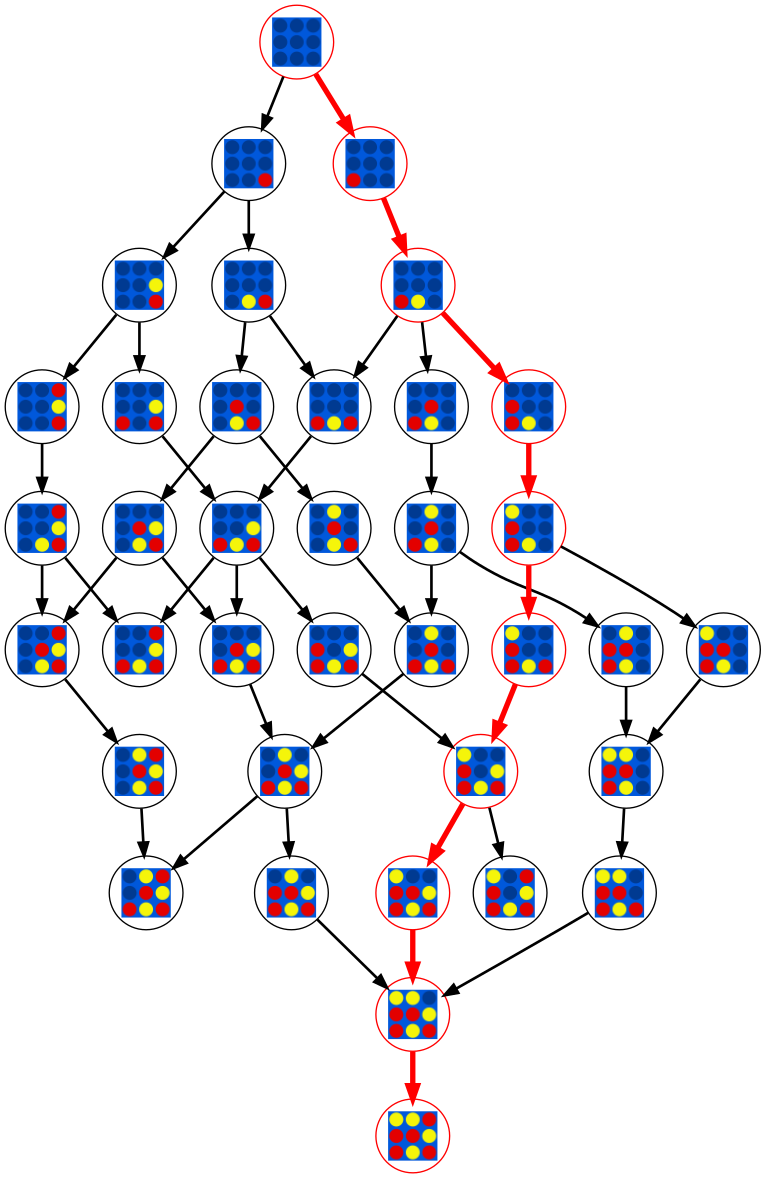

In [23]:
draw(G, format='png',filename='output/{}x{}/full.png'.format(NUM_COLS, NUM_ROWS))

While the ruleset has constraints that prevent states that are inconsistent with the known end-state, there are (sometimes) still "hanging" states that are consistent with it but can never meet it. As such, we prune impossible provenance (i.e. remove all edges that do not lead to the known final state).

In [24]:
from networkx.algorithms.shortest_paths.generic import has_path

In [25]:
#Prune all paths that do not lead to the known end state
nodes_to_remove = []
for node in G.nodes:
    if not has_path(G, node, known_end):
        nodes_to_remove.append(node)
        
for node in nodes_to_remove:
    G.remove_node(node)

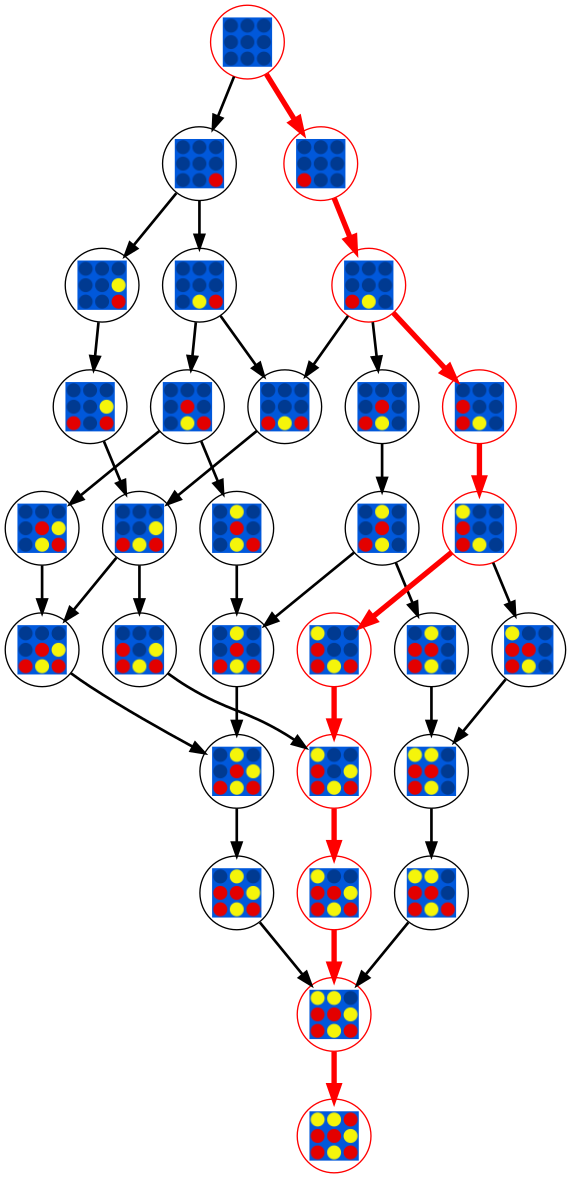

In [26]:
draw(G, format='png',filename='output/{}x{}/possible.png'.format(NUM_COLS, NUM_ROWS))

## Analysis
Now that we have the final graph of possible provenances, we can compute some metrics to determine the existence and viability of paths other than the "true" path

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

### Correctness
Does the real ground truth exist in the set of all possible generated paths? If not, this suggests something is fundamentally flawed in our abstract model of the system (and something has probably thrown an exception before we got to this point anyway). However, failing that, is there at least *some* route from the known start to the known end, which may at least contain a portion (or abstraction) of the true provenance?

In [28]:
for node in known_provenance:
    if node not in G:
        print("False")
        break
else:
    print("True")

True


In [29]:
has_path(G, known_start, known_end)

True

### Attributes
Some basic graph metrics of the generated paths, including degree, density, etc.

In [30]:
from networkx.algorithms.shortest_paths.generic import shortest_path_length
from networkx.algorithms.simple_paths import all_simple_paths, shortest_simple_paths
from networkx.classes.function import *

In [31]:
print(info(G))

Name: 
Type: DiGraph
Number of nodes: 30
Number of edges: 38
Average in degree:   1.2667
Average out degree:   1.2667


In [32]:
degree_histogram(G)

[0, 1, 15, 11, 3]

In [33]:
average_degree = 0
for i, d in enumerate(degree_histogram(G)):
    average_degree += (i+1 * d)
average_degree = float(average_degree)/sum(degree_histogram(G))
average_degree

1.3333333333333333

In [34]:
density(G)

0.04367816091954023

In [35]:
# How many non-true/superfluous paths are generated?
len(list(all_simple_paths(G, known_start, known_end)))-1

11

In [36]:
# Average path length
average_path_length = 0
for path in all_simple_paths(G, known_start, known_end):
    average_path_length += len(path) - 1
average_path_length = float(average_path_length)/len(list(all_simple_paths(G, known_start, known_end)))
average_path_length

9.0

In [37]:
shortest_path_length(G, known_start, known_end)

9

In [38]:
#Is the ground truth (one of) the shortest path(s)?
len(known_provenance)-1 == shortest_path_length(G, known_start, known_end)

True

### Accuracy
For each possible path from the known start to the known end, how accurate was it? What features does it share with the true path? What features differ?

In [39]:
# This assumes that all values in the path are unique
# Which is the case for Connect 4, but not necessarily for all problems

# This also currently counts the "known-start" and "known-end" nodes;
# for short paths, this may somewhat affect the accuracy
def shared_nodes(path1, path2):
    return len(set(path1) & set(path2)) / float(max(len(path1), len(path2)))

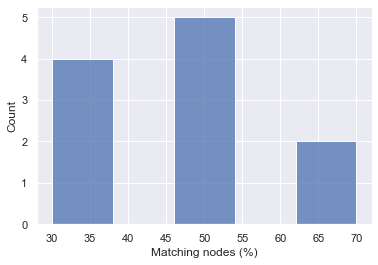

In [40]:
accuracy_dist = []

for path in all_simple_paths(G, known_start, known_end):
    if path != known_provenance:
        accuracy_dist.append(shared_nodes(path, known_provenance)*100)
        
ax = sns.histplot(accuracy_dist)
ax.set(xlabel='Matching nodes (%)')
ax.get_figure().savefig('output/{}x{}/eval/accuracy.png'.format(NUM_COLS, NUM_ROWS))
        

### Variance
For every node in the true path, what percentage of the other paths pass through it?

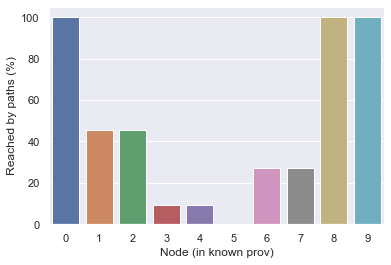

In [41]:
variance = []

# Here we are only considering the "other" possible paths
paths = [p for p in all_simple_paths(G, known_start, known_end) if p != known_provenance]

for node_index, node in enumerate(known_provenance):
    matched = 0
    for path in paths:
        if path != known_provenance and node in path:
            matched += 1
    variance.append((matched/len(paths))*100)
    
    
ax = sns.barplot(x=list(range(len(variance))), y=variance)
ax.set(ylabel='Reached by paths (%)')
ax.set(xlabel='Node (in known prov)')
ax.get_figure().savefig('output/{}x{}/eval/variance.png'.format(3, 3))


### Features of Interest
What other interesting features are observable in the graph? For instance, do all paths pass through a single "mid-point" node? If so, this could be used as a "Known Capture Point" (see below).

In [42]:
# Very similar to the code above; however, here we consider all nodes, rather than just those in the known_provenance
# This will allow us to, in theory, divert resources to better capturing the provenance in-situ, by recognising the most
# likely cokepoints in the graph

paths = [p for p in all_simple_paths(G, known_start, known_end)]

for node_index, node in enumerate(G):

    # Discount the start and end - *obviously* all paths pass through those
    if node == known_start or node == known_end:
        continue
    
    node_count = 0
    for path in paths:
        if node in path:
            node_count += 1
    node_count = (float(node_count)/len(paths)) * 100
    
    print("Node {} reached by {}% of paths".format(node_index, node_count))

Node 1 reached by 50.0% of paths
Node 2 reached by 50.0% of paths
Node 3 reached by 16.666666666666664% of paths
Node 4 reached by 33.33333333333333% of paths
Node 5 reached by 50.0% of paths
Node 6 reached by 16.666666666666664% of paths
Node 7 reached by 16.666666666666664% of paths
Node 8 reached by 16.666666666666664% of paths
Node 9 reached by 33.33333333333333% of paths
Node 10 reached by 16.666666666666664% of paths
Node 11 reached by 8.333333333333332% of paths
Node 12 reached by 16.666666666666664% of paths
Node 13 reached by 16.666666666666664% of paths
Node 14 reached by 50.0% of paths
Node 15 reached by 8.333333333333332% of paths
Node 16 reached by 33.33333333333333% of paths
Node 17 reached by 8.333333333333332% of paths
Node 18 reached by 25.0% of paths
Node 19 reached by 8.333333333333332% of paths
Node 20 reached by 8.333333333333332% of paths
Node 21 reached by 16.666666666666664% of paths
Node 22 reached by 50.0% of paths
Node 23 reached by 16.666666666666664% of pat

## Known Capture Points
Now let us assume that there are additional known states, or intermediate capture points, between the start and end states. This effectively breaks the problem space into two, and we can evaluate each in turn.

In [43]:
kcp = known_provenance[round(len(known_provenance)/2)]

H = G.copy()
H.nodes[kcp]['color'] = 'blue'

In [44]:
#Prune all paths that do not lead to or from the known capture point
nodes_to_remove = []
for node in H.nodes:
    if not has_path(H, node, kcp) and not has_path(H, kcp, node):
        nodes_to_remove.append(node)
        
for node in nodes_to_remove:
    H.remove_node(node)

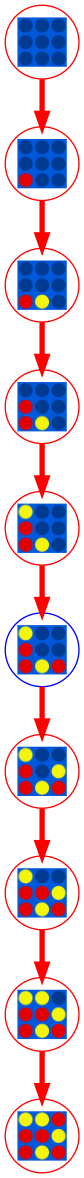

In [45]:
draw(H, format='png',filename='output/{}x{}/kcp.png'.format(NUM_COLS, NUM_ROWS))